In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 410097763.31it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39742681.70it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 142739910.35it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2285880.58it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [3]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [4]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [6]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [7]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.197266
Train Epoch: 1 [10000/60000 (17%)]	Loss: 189.492891
Train Epoch: 1 [20000/60000 (33%)]	Loss: 177.939141
Train Epoch: 1 [30000/60000 (50%)]	Loss: 176.517246
Train Epoch: 1 [40000/60000 (67%)]	Loss: 170.871895
Train Epoch: 1 [50000/60000 (83%)]	Loss: 173.266738
====> Epoch: 1 Average loss: 181.4250
====> Test set loss: 163.3361
Train Epoch: 2 [0/60000 (0%)]	Loss: 165.831562
Train Epoch: 2 [10000/60000 (17%)]	Loss: 160.795127
Train Epoch: 2 [20000/60000 (33%)]	Loss: 160.542480
Train Epoch: 2 [30000/60000 (50%)]	Loss: 164.061387
Train Epoch: 2 [40000/60000 (67%)]	Loss: 163.402480
Train Epoch: 2 [50000/60000 (83%)]	Loss: 158.658867
====> Epoch: 2 Average loss: 158.4876
====> Test set loss: 155.0297
Train Epoch: 3 [0/60000 (0%)]	Loss: 149.603945
Train Epoch: 3 [10000/60000 (17%)]	Loss: 162.194922
Train Epoch: 3 [20000/60000 (33%)]	Loss: 148.262803
Train Epoch: 3 [30000/60000 (50%)]	Loss: 160.278574
Train Epoch: 3 [40000/60000 (67%)]	Loss: 153.97

In [9]:
import matplotlib.pyplot as plt

<class 'torch.Tensor'>
torch.Size([64, 784])


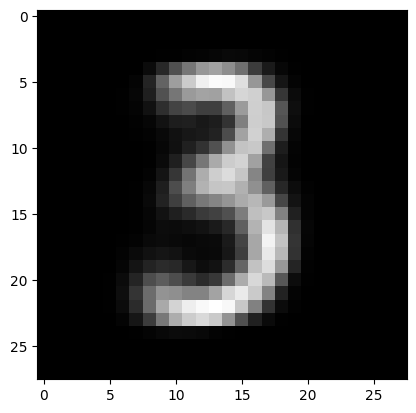

In [62]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    print(sample.__class__)
    print(sample.size())

    sample = sample.cpu() # use .cpu().numpy() to move off the GPU ## NOTE: moving to numpy is redundant and unhelpful 
    image = sample[0].reshape(28,28)    # shows the first of 64 randimly generated pictures
    plt.imshow(image, cmap="gray")
  

    #plt.imshow(sample[0].reshape(28,28), cmap="gray")
    #save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

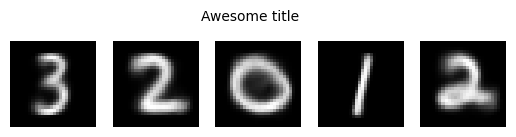

In [68]:
#plt.imshow(sample[0].reshape(28,28).cpu().numpy().reshape(28,28), cmap="gray")

images = sample[:5].reshape((-1, 28, 28))  # se

fig, axes = plt.subplots(nrows=1, ncols=5)  # create a 4x4 grid of subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')  # display image on the current subplot

[axi.set_axis_off() for axi in axes.ravel()] # kill axes h/t https://stackoverflow.com/questions/25862026/turn-off-axes-in-subplots
fig.suptitle('Awesome title', fontsize=10, y=.65) # awesome title h/t https://www.geeksforgeeks.org/how-to-set-a-single-main-title-for-all-the-subplots-in-matplotlib/
plt.show()

In [67]:
## now create an image of estimated images and ground truth
# read https://stackoverflow.com/questions/66667949/pytorch-mnist-autoencoder-to-learn-10-digit-classification

tensor([[ 0.2309,  0.5520],
        [ 0.6513, -0.2254],
        [ 1.7023, -0.5172],
        [-2.0563,  0.3679],
        [ 0.9158, -0.3996],
        [-0.9992, -0.5305],
        [-0.2402, -0.8536],
        [ 1.2527, -0.2682],
        [-1.2756, -1.0370],
        [-1.7166, -0.7432],
        [-0.9168, -0.1997],
        [ 1.7092,  0.7411],
        [-0.0486, -0.4489],
        [-1.5048,  0.5775],
        [ 1.8482,  0.2017],
        [ 0.8992, -0.3755],
        [ 2.1350,  1.8131],
        [-0.5353, -0.3398],
        [-0.8082, -0.6721],
        [-0.0246, -1.4348],
        [ 0.8871,  0.6801],
        [ 1.3288,  0.9755],
        [-1.5308, -0.5648],
        [ 0.0819, -1.1823],
        [ 0.4068, -0.4120],
        [-0.2359, -0.9018],
        [ 0.2432,  2.8971],
        [-0.4148,  1.2791],
        [ 0.3457, -0.7802],
        [-1.4416, -1.4697],
        [ 0.2846,  0.4996],
        [ 1.3944, -0.8940],
        [-0.1940,  0.2500],
        [-0.5367, -0.3388],
        [-0.5329,  0.7821],
        [-0.3183,  1

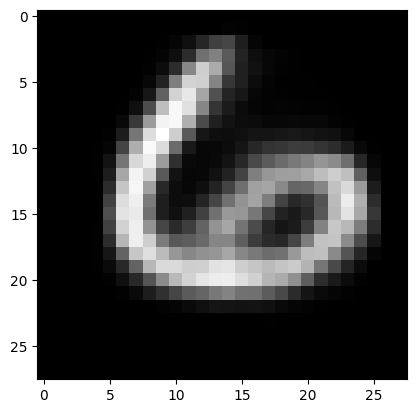

In [28]:


fig, axes = plt.subplots(nrows=1, ncols=5)  # create a 4x4 grid of subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')  # display image on the current subplot

[axi.set_axis_off() for axi in axes.ravel()] # kill axes h/t https://stackoverflow.com/questions/25862026/turn-off-axes-in-subplots
fig.suptitle('Awesome title', fontsize=10, y=.65) # awesome title h/t https://www.geeksforgeeks.org/how-to-set-a-single-main-title-for-all-the-subplots-in-matplotlib/
plt.show()

In [ ]:
# now create five images similarly to MNIST_data_wrangling.ipynb